In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
import itertools
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,max_error,explained_variance_score

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge


# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
df = pd.read_excel("finaldata.xlsx")

In [3]:
df.drop_duplicates(subset=['TimeStamp'])

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.280,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.180,1,1,1,1
2,2019-01-01 02:00:00,1993.39,2613.60,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,8.4,82.0,60.910,1,1,2,1
3,2019-01-01 03:00:00,1752.69,2470.13,489.53,0.4832,124.1,0.0,35.6,190.7,451.6,8.6,82.0,65.160,1,1,3,1
4,2019-01-01 04:00:00,1717.17,2384.35,378.44,0.4460,124.4,0.0,36.0,197.1,458.5,8.4,85.0,65.160,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30615,2022-06-29 19:00:00,3978.34,3879.64,367.16,0.0931,116.3,456.0,146.4,96.5,1658.4,15.8,73.0,245.195,29,6,19,2
30616,2022-06-29 20:00:00,3843.57,3725.62,311.32,0.0751,92.3,450.7,123.8,93.6,1678.3,14.5,80.0,245.195,29,6,20,2
30617,2022-06-29 21:00:00,3796.31,3601.76,290.98,0.0668,80.5,450.7,122.2,93.6,1649.8,14.0,77.0,228.590,29,6,21,2
30618,2022-06-29 22:00:00,3754.00,3467.82,309.83,0.0732,59.7,340.1,121.5,96.1,1630.2,13.3,82.0,228.590,29,6,22,2


In [4]:
data=df.copy()
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
#data = data.set_index('TimeStamp')
#data = data.asfreq('H')
#data = data.sort_index()
data.head(2)

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18,1,1,1,1


In [5]:
data=data.fillna(method='ffill')
data['ElectricityPrice'] = data['ElectricityPrice'].fillna(0)
data['IE Demand'] = data['IE Demand'].fillna(0)

In [6]:
data=data.drop(data[data['TimeStamp']>pd.to_datetime('31-12-2021  23:00:00')].index)
data.shape

(26301, 17)

In [7]:
min_date = data['TimeStamp'].min()
max_date = data['TimeStamp'].max()
print("Min:", min_date, "Max:", max_date)
train_percent = .80
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Min: 2019-01-01 00:00:00 Max: 2021-12-31 23:00:00


Timestamp('2021-05-26 18:24:00')

In [8]:
train_df = data[data['TimeStamp'] <= train_cutoff]
test_df = data[data['TimeStamp'] > train_cutoff]


print("Train:", train_df.index.min(), train_df.index.max(), len(train_df))
print("Test:", test_df.index.min(), test_df.index.max(), len(test_df))

Train: 0 21039 21040
Test: 21040 26300 5261


In [47]:
exogenous_features = list(data)
exogenous_features.remove('ElectricityPrice')
exogenous_features.remove('TimeStamp')
exogenous_features.remove('SNSP')
exogenous_features.remove('temp')
exogenous_features.remove('day')
exogenous_features.remove('rhum')
exogenous_features.remove('Hydro Run-of-River')
exogenous_features.remove('IE Generation')
exogenous_features.remove('Fossil peat')
exogenous_features.remove('IE Wind Generation')
exogenous_features

['IE Demand',
 'Fossil hard coal',
 'Fossil oil',
 'Fossil gas',
 'month',
 'hour',
 'dayofweek']

In [48]:
from prophet import Prophet
model = Prophet()

In [49]:
for feature in exogenous_features:
	model.add_regressor(feature)

In [ ]:
train_df.head(2)

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18,1,1,1,1


In [50]:
model.fit(train_df[["TimeStamp", "ElectricityPrice"] + exogenous_features].rename(columns={"TimeStamp": "ds", "ElectricityPrice": "y"}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdmjbmw2s/o3rt8rvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdmjbmw2s/e41z_lff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26732', 'data', 'file=/tmp/tmpdmjbmw2s/o3rt8rvw.json', 'init=/tmp/tmpdmjbmw2s/e41z_lff.json', 'output', 'file=/tmp/tmpdmjbmw2s/prophet_model80vlsx9z/prophet_model-20230702102724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:27:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:27:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [51]:
forecast = model.predict(test_df[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

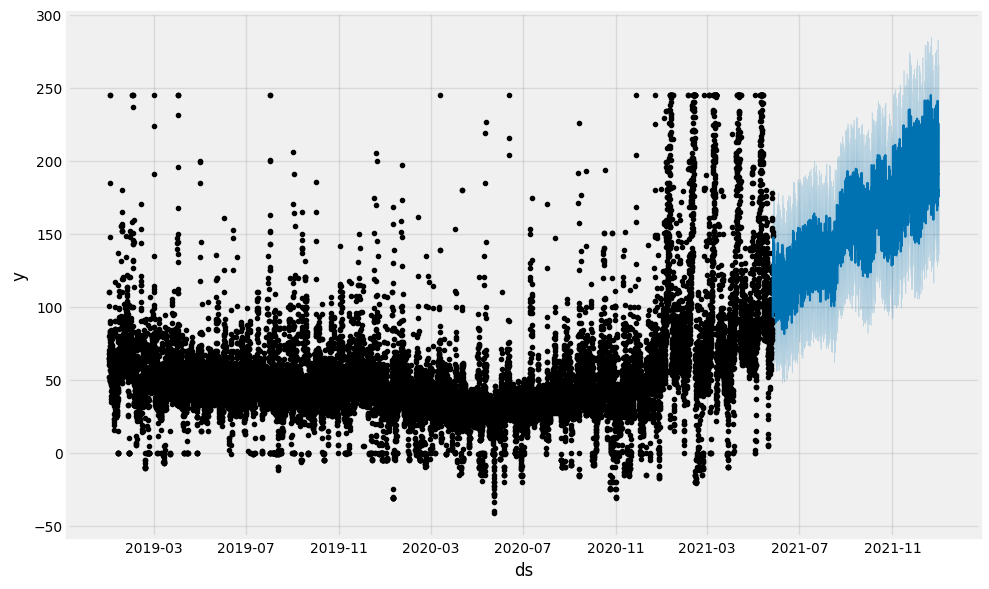

In [52]:
fig1 = model.plot(forecast)

In [ ]:
test_df.head(2)

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
21040,2021-05-26 19:00:00,3048.61,3807.30,166.50,0.2488,122.4,626.9,549.2,113.1,232.1,13.2,63.0,116.38,26,5,19,2
21041,2021-05-26 20:00:00,3099.42,3668.78,176.91,0.2139,126.9,626.9,500.5,117.2,176.4,12.4,71.0,111.93,26,5,20,2


In [ ]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Fossil gas,Fossil gas_lower,Fossil gas_upper,Fossil hard coal,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-26 19:00:00,99.950313,92.759681,154.803111,99.950313,99.950313,-1.013589,-1.013589,-1.013589,14.416767,...,-1.563934,-1.563934,-1.563934,0.967243,0.967243,0.967243,0.0,0.0,0.0,125.570368
1,2021-05-26 20:00:00,99.961525,80.187218,146.280368,99.961525,99.961525,-1.096566,-1.096566,-1.096566,14.416767,...,-1.589655,-1.589655,-1.589655,0.948837,0.948837,0.948837,0.0,0.0,0.0,113.190185


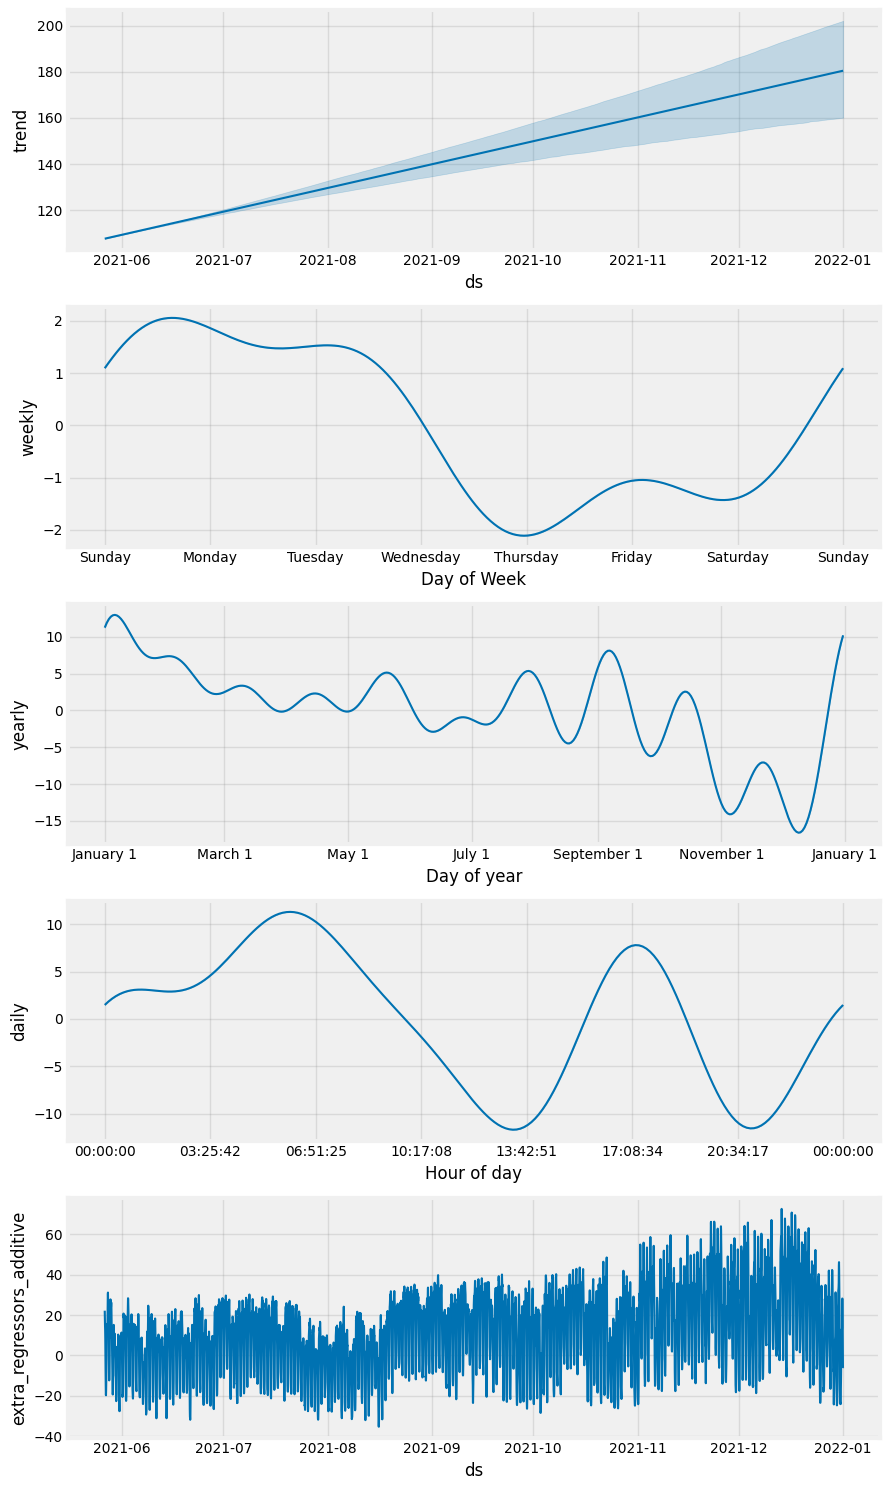

In [53]:
fig2 = model.plot_components(forecast)

In [54]:
result = forecast.copy()

In [ ]:
result.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Fossil gas,Fossil gas_lower,Fossil gas_upper,Fossil hard coal,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-26 19:00:00,99.950313,92.759681,154.803111,99.950313,99.950313,-1.013589,-1.013589,-1.013589,14.416767,...,-1.563934,-1.563934,-1.563934,0.967243,0.967243,0.967243,0.0,0.0,0.0,125.570368
1,2021-05-26 20:00:00,99.961525,80.187218,146.280368,99.961525,99.961525,-1.096566,-1.096566,-1.096566,14.416767,...,-1.589655,-1.589655,-1.589655,0.948837,0.948837,0.948837,0.0,0.0,0.0,113.190185


In [55]:
result['TimeStamp'] = pd.to_datetime(result['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result = result.set_index('TimeStamp')
result = result.asfreq('H')
result = result.sort_index()

In [10]:
dftest = test_df.copy()

In [11]:
dftest['TimeStamp'] = pd.to_datetime(dftest['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
dftest = dftest.set_index('TimeStamp')
dftest = dftest.asfreq('H')
dftest = dftest.sort_index()

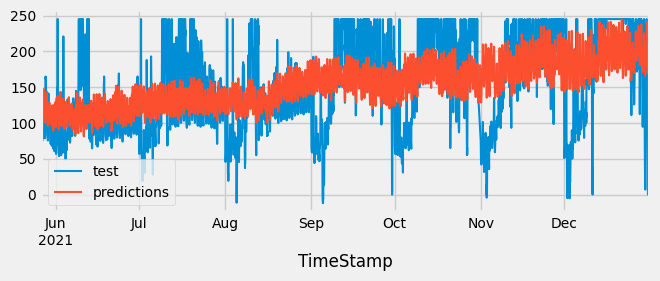

In [56]:
fig, ax = plt.subplots(figsize=(7, 2.5))

dftest['ElectricityPrice'].plot(ax=ax, label='test')
#forecast['yhat_lower'].plot(ax=ax, label='lower')
#forecast['yhat_upper'].plot(ax=ax, label='upper')
result['yhat'].plot(ax=ax, label='predictions')
ax.legend();

In [58]:
y_pred=result['yhat']
y_test=test_df['ElectricityPrice']

In [59]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 52.64066099282721
MSE: 2771.0391897617596
MAE: 41.33121880902635
MAPE: 895254611208691.9
Max Error: 180.69894493430928
Explained Variance Score: 0.3314461450537336
R2Score: 0.3310996967065367


In [60]:
from prophet.utilities import regressor_coefficients
regressor_coef = regressor_coefficients(model)
regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

,regressor,regressor_mode,coef
3,Fossil gas,additive,0.012338
2,Fossil oil,additive,0.016021
0,IE Demand,additive,0.021563
1,Fossil hard coal,additive,0.031386
4,month,additive,0.154478
5,hour,additive,0.184733
6,dayofweek,additive,0.617450


In [ ]:
r2_score(test_df['ElectricityPrice'], forecast['yhat'])

0.23192475098426435

In [ ]:
mean_squared_error(test_df['ElectricityPrice'], forecast['yhat'])

3181.8891473500476

In [ ]:
mean_absolute_error(test_df['ElectricityPrice'], forecast['yhat'])

45.786330778002096

In [61]:
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [62]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_df[["TimeStamp", "ElectricityPrice"] + exogenous_features].rename(columns={"TimeStamp": "ds", "ElectricityPrice": "y"}))  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdmjbmw2s/9y42vgr1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdmjbmw2s/b89iba13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43855', 'data', 'file=/tmp/tmpdmjbmw2s/9y42vgr1.json', 'init=/tmp/tmpdmjbmw2s/b89iba13.json', 'output', 'file=/tmp/tmpdmjbmw2s/prophet_modeldypop2yh/prophet_model-20230702103111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:31:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:31:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2020-01-02 18:00:00 and 2021-04-26 18:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd73d7d4be0>
DEBUG:cmdstanpy:input tempfile:

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  37.149615
1                     0.001                     0.10  37.368300
2                     0.001                     1.00  37.265405
3                     0.001                    10.00  37.458797
4                     0.010                     0.01  35.051889
5                     0.010                     0.10  35.085378
6                     0.010                     1.00  35.048066
7                     0.010                    10.00  35.056396
8                     0.100                     0.01  35.849698
9                     0.100                     0.10  37.911796
10                    0.100                     1.00  37.739587
11                    0.100                    10.00  38.062901
12                    0.500                     0.01  40.248780
13                    0.500                     0.10  55.337114
14                    0.500             

In [63]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


In [64]:
model2 = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale= 1.0)

In [65]:
for feature in exogenous_features:
	model2.add_regressor(feature)

In [66]:
model2.fit(train_df[["TimeStamp", "ElectricityPrice"] + exogenous_features].rename(columns={"TimeStamp": "ds", "ElectricityPrice": "y"}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdmjbmw2s/k0t6h2d9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdmjbmw2s/okt7nxgw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28890', 'data', 'file=/tmp/tmpdmjbmw2s/k0t6h2d9.json', 'init=/tmp/tmpdmjbmw2s/okt7nxgw.json', 'output', 'file=/tmp/tmpdmjbmw2s/prophet_modelnbq7_jh8/prophet_model-20230702114152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:41:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:41:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [67]:
forecast2 = model2.predict(test_df[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

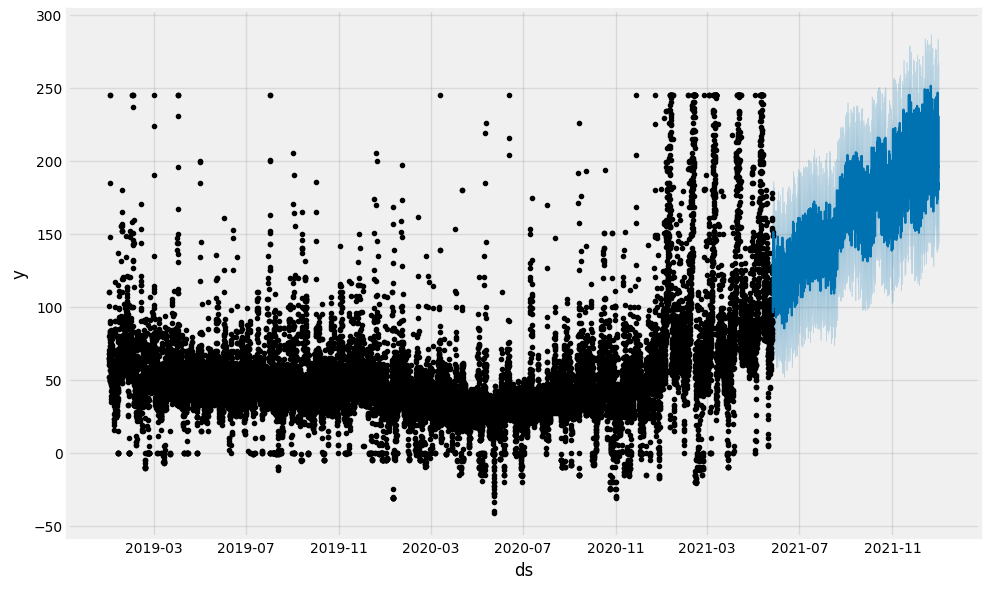

In [68]:
fig3 = model2.plot(forecast2)

In [69]:
forecast2.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Fossil gas,Fossil gas_lower,Fossil gas_upper,Fossil hard coal,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-26 19:00:00,110.875778,101.957727,170.37329,110.875778,110.875778,-8.104528,-8.104528,-8.104528,17.754921,...,-2.075206,-2.075206,-2.075206,2.233523,2.233523,2.233523,0.0,0.0,0.0,134.323421
1,2021-05-26 20:00:00,110.890132,87.303529,155.23113,110.890132,110.890132,-8.768001,-8.768001,-8.768001,17.754921,...,-2.110587,-2.110587,-2.110587,2.218383,2.218383,2.218383,0.0,0.0,0.0,122.506480


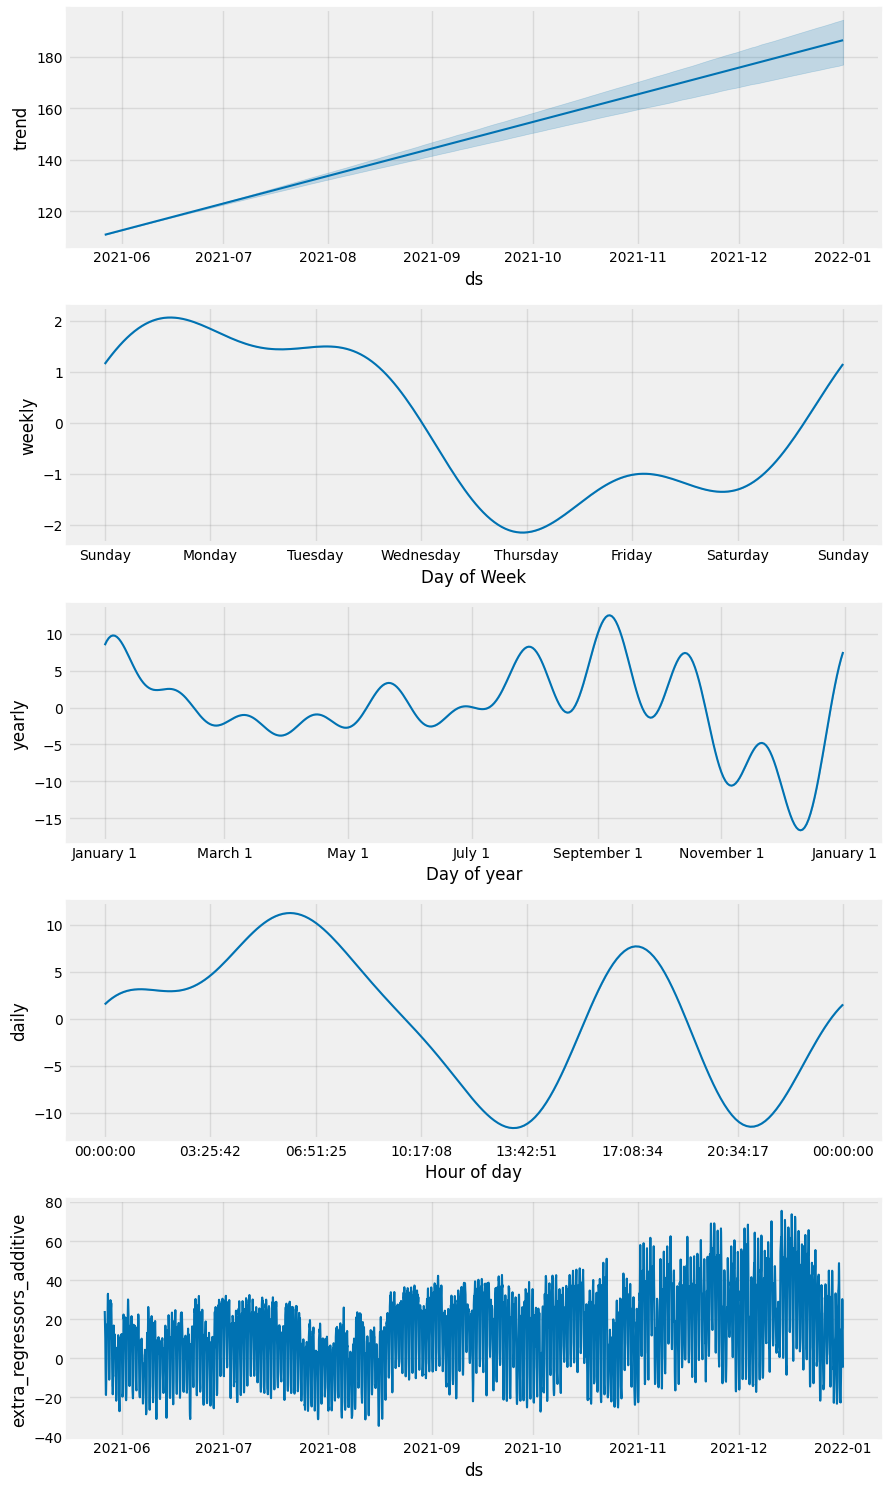

In [70]:
fig4 = model2.plot_components(forecast2)

In [71]:
result2 = forecast2.copy()

In [72]:
result2.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Fossil gas,Fossil gas_lower,Fossil gas_upper,Fossil hard coal,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-26 19:00:00,110.875778,101.957727,170.37329,110.875778,110.875778,-8.104528,-8.104528,-8.104528,17.754921,...,-2.075206,-2.075206,-2.075206,2.233523,2.233523,2.233523,0.0,0.0,0.0,134.323421
1,2021-05-26 20:00:00,110.890132,87.303529,155.23113,110.890132,110.890132,-8.768001,-8.768001,-8.768001,17.754921,...,-2.110587,-2.110587,-2.110587,2.218383,2.218383,2.218383,0.0,0.0,0.0,122.506480


In [73]:
result2['TimeStamp'] = pd.to_datetime(result2['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result2 = result2.set_index('TimeStamp')
result2 = result2.asfreq('H')
result2 = result2.sort_index()

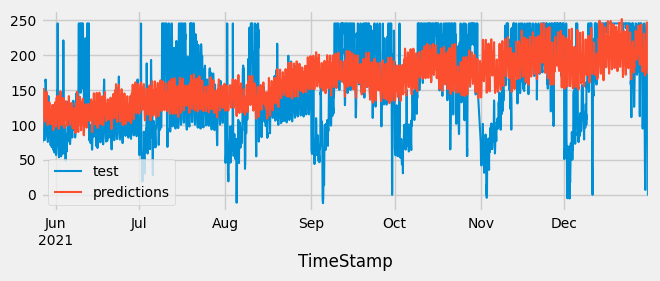

In [74]:
fig, ax = plt.subplots(figsize=(7, 2.5))

dftest['ElectricityPrice'].plot(ax=ax, label='test')
#forecast['yhat_lower'].plot(ax=ax, label='lower')
#forecast['yhat_upper'].plot(ax=ax, label='upper')
result2['yhat'].plot(ax=ax, label='predictions')
ax.legend();

In [75]:
y_pred=result2['yhat']
y_test=test_df['ElectricityPrice']

In [76]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 53.59068252132218
MSE: 2871.9612531011467
MAE: 41.557971681170855
MAPE: 940552850758888.8
Max Error: 189.51344140163718
Explained Variance Score: 0.3308200540314147
R2Score: 0.3067381506749477


In [77]:
from prophet.utilities import regressor_coefficients
regressor_coef = regressor_coefficients(model2)
regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

,regressor,regressor_mode,coef
3,Fossil gas,additive,0.011912
2,Fossil oil,additive,0.017469
0,IE Demand,additive,0.021479
1,Fossil hard coal,additive,0.034299
5,hour,additive,0.186197
4,month,additive,0.363415
6,dayofweek,additive,0.613500


In [29]:
r2_score(test_df['ElectricityPrice'], forecast2['yhat'])

0.26951341116146643

In [ ]:
mean_squared_error(test_df['ElectricityPrice'], forecast2['yhat'])

3026.171396993509

In [ ]:
mean_absolute_error(test_df['ElectricityPrice'], forecast2['yhat'])

44.33345878725421

In [78]:
pred_data=df.copy()
pred_data['TimeStamp'] = pd.to_datetime(pred_data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')

In [79]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data.shape

(4319, 17)

In [80]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']>pd.to_datetime('01-07-2022  00:00:00')].index)
pred_data.shape

(145, 17)

In [81]:
forecast3 = model2.predict(pred_data[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

In [82]:
result3 = forecast3.copy()

In [83]:
result3['TimeStamp'] = pd.to_datetime(result3['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result3 = result3.set_index('TimeStamp')
result3 = result3.asfreq('H')
result3 = result3.sort_index()

In [84]:
pred_data = pred_data.set_index('TimeStamp')
pred_data = pred_data.asfreq('H')
pred_data = pred_data.sort_index()

In [85]:
plottest=dftest.drop(dftest[dftest.index<pd.to_datetime('30-11-2021  23:00:00')].index)

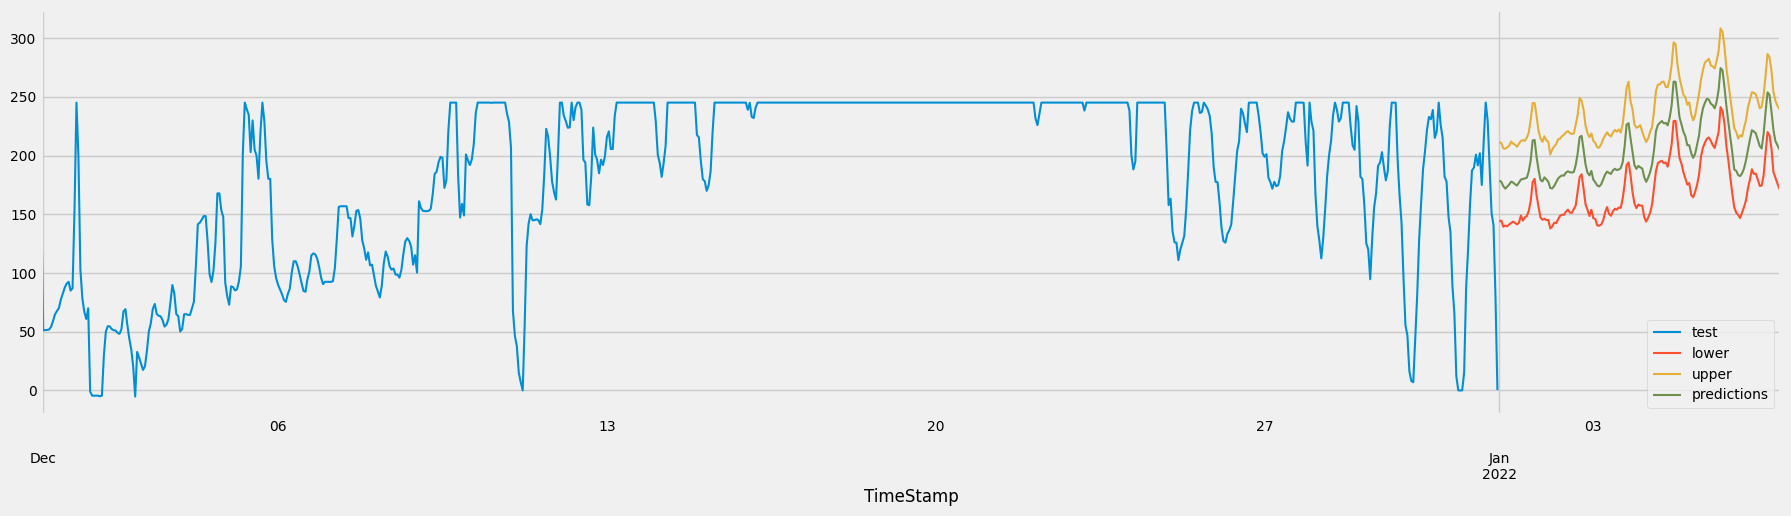

In [86]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')
plottest['ElectricityPrice'].plot(ax=ax, label='test')
result3['yhat_lower'].plot(ax=ax, label='lower')
result3['yhat_upper'].plot(ax=ax, label='upper')
result3['yhat'].plot(ax=ax, label='predictions')
ax.fill_between(result3['yhat'],result3['yhat_upper'],result3['yhat_lower'], color='blue', alpha=0.1)
ax.legend();
plt.show()

In [87]:
pred_data2=df.copy()
pred_data2['TimeStamp'] = pd.to_datetime(pred_data2['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
pred_data2=pred_data2.drop(pred_data2[pred_data2['TimeStamp']<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data2=pred_data2.drop(pred_data2[pred_data2['TimeStamp']>=pd.to_datetime('01-02-2022  00:00:00')].index)
pred_data2.shape

(24, 17)

In [88]:
forecast4 = model2.predict(pred_data2[["TimeStamp"] + exogenous_features].rename(columns={"TimeStamp": "ds"}))

In [89]:
pred_data2 = pred_data2.set_index('TimeStamp')
pred_data2 = pred_data2.asfreq('H')
pred_data2 = pred_data2.sort_index()

In [90]:
result4=forecast4.copy()
result4['TimeStamp'] = pd.to_datetime(result4['ds'], format='%Y-%m-%dT%H:%M:%SZ')
result4 = result4.set_index('TimeStamp')
result4 = result4.asfreq('H')
result4 = result4.sort_index()

In [91]:
plottest=dftest.drop(dftest[dftest.index<pd.to_datetime('28-12-2021  23:00:00')].index)

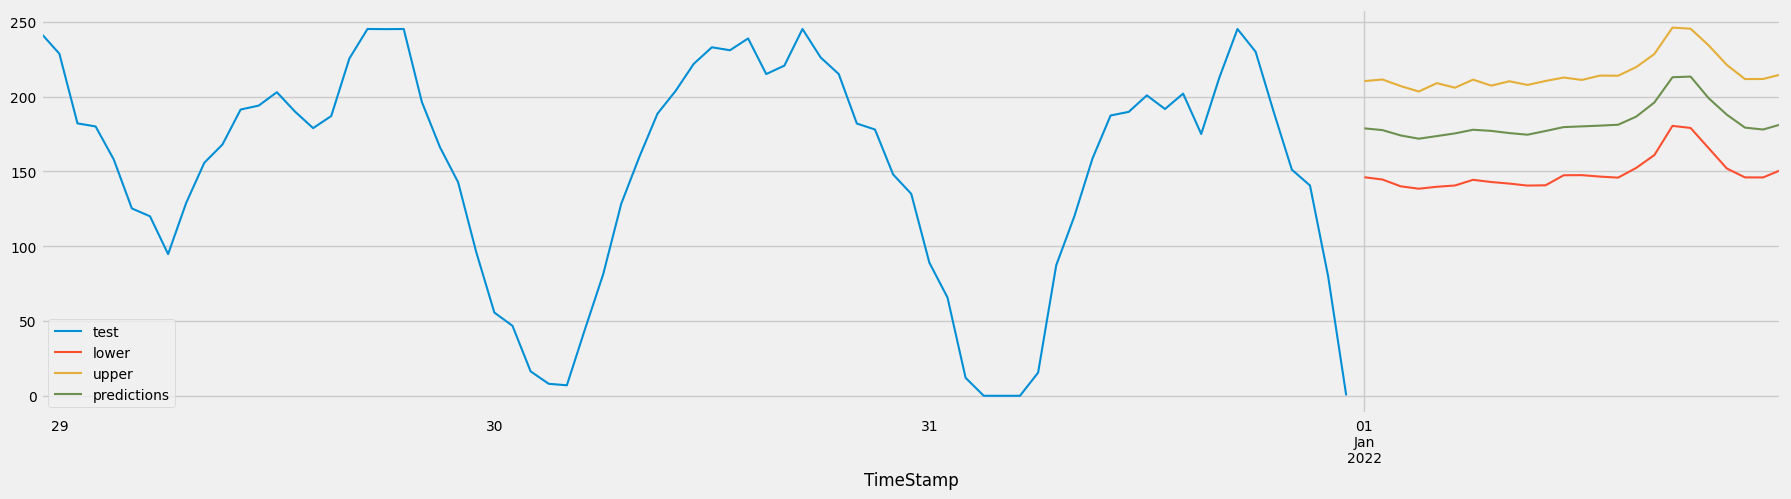

In [92]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')
plottest['ElectricityPrice'].plot(ax=ax, label='test')
result4['yhat_lower'].plot(ax=ax, label='lower')
result4['yhat_upper'].plot(ax=ax, label='upper')
result4['yhat'].plot(ax=ax, label='predictions')
#ax.fill_between(result3['yhat'],result3['yhat_upper'],result3['yhat_lower'], color='blue', alpha=0.1)
ax.legend();
plt.show()